In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

In [14]:
df_raw = pd.read_csv('data/missoula_valley_monitored_wells.csv', parse_dates=['time'], index_col='time')
df_filled = pd.read_csv('data/missoula_valley_wells_imputed_qreg.csv')
df_pump = pd.read_csv('data/mso_monthly_pumping_rates.csv')

### Heatmap of all data and gaps

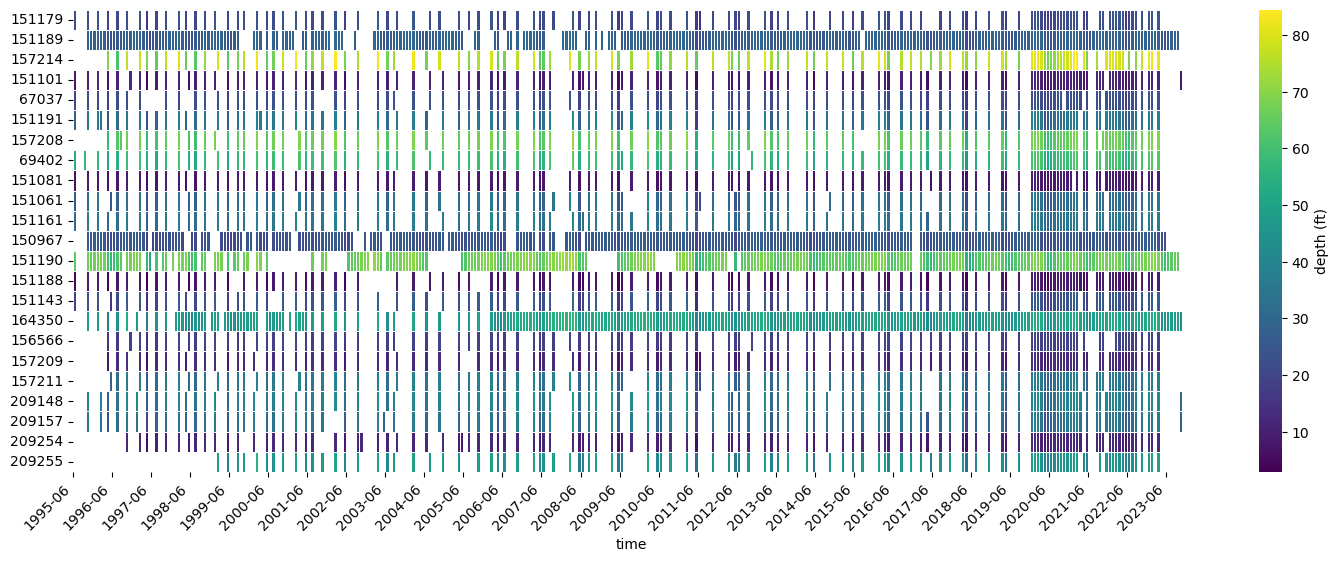

In [15]:
fig, ax = plt.subplots(figsize=(18, 6))
fig = sns.heatmap(df_raw.transpose(), 
                  cmap='viridis', 
                  cbar=True, 
                  linewidth=0.5, 
                  ax=ax, 
                  cbar_kws={'label': 'depth (ft)'})
xdates = df_raw.index.strftime('%Y-%m').sort_values().unique()
step = 12
ax.set_xticks(np.arange(0, len(xdates), step=step))
ax.set_xticklabels(xdates[::step], rotation=45, ha='right')
plt.show()

### Plot timeseries of all wells

In [16]:
df_melt = df_filled.drop(columns='Q').melt(id_vars='time')
df_melt['time'] = pd.to_datetime(df_melt['time'])

In [17]:
# Calculate trends and p-values and add to the DataFrame
df_trend = df_melt.copy()
df_trend['time'] = df_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)
def get_trend(x):
    """Define a function to fit a linear regression model and return the slope, 
    intercept, and p-value."""
    model = ols('value ~ time', data=x).fit()
    return pd.Series([model.params['Intercept'], 
                      model.params['time'], 
                      model.pvalues['time']], 
                     index=['intercept', 'slope', 'p-value'])

# Group the data by the 'variable' column and apply the 'get_trend' function
trends = df_trend.groupby('variable').apply(get_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_trend = df_trend.join(trends, on='variable')

In [29]:
# Define a function to plot the data and the trendline
def plot_data_and_trendline(data, color):
    x = data['time']
    y = data['value']
    slope = data['slope'].iloc[0]
    intercept = data['intercept'].iloc[0]
    p_value = data['p-value'].iloc[0]
    
    # Convert the 'time' column to datetime for plotting
    x_datetime = pd.to_datetime(x, unit='s')
    
    # Plot the data
    plt.plot(x_datetime, y)
    
    # Set the color of the trendline based on the p-value
    trend_color = 'red' if p_value < 0.1 else 'black'

    # Add the p-value to the plot
    plt.text(0.15, 0.1, f'p-value: {p_value:.2f}', ha='left', va='top', transform=plt.gca().transAxes)

    # Plot the trendline
    plt.plot(x_datetime, intercept + slope * x, color=trend_color)

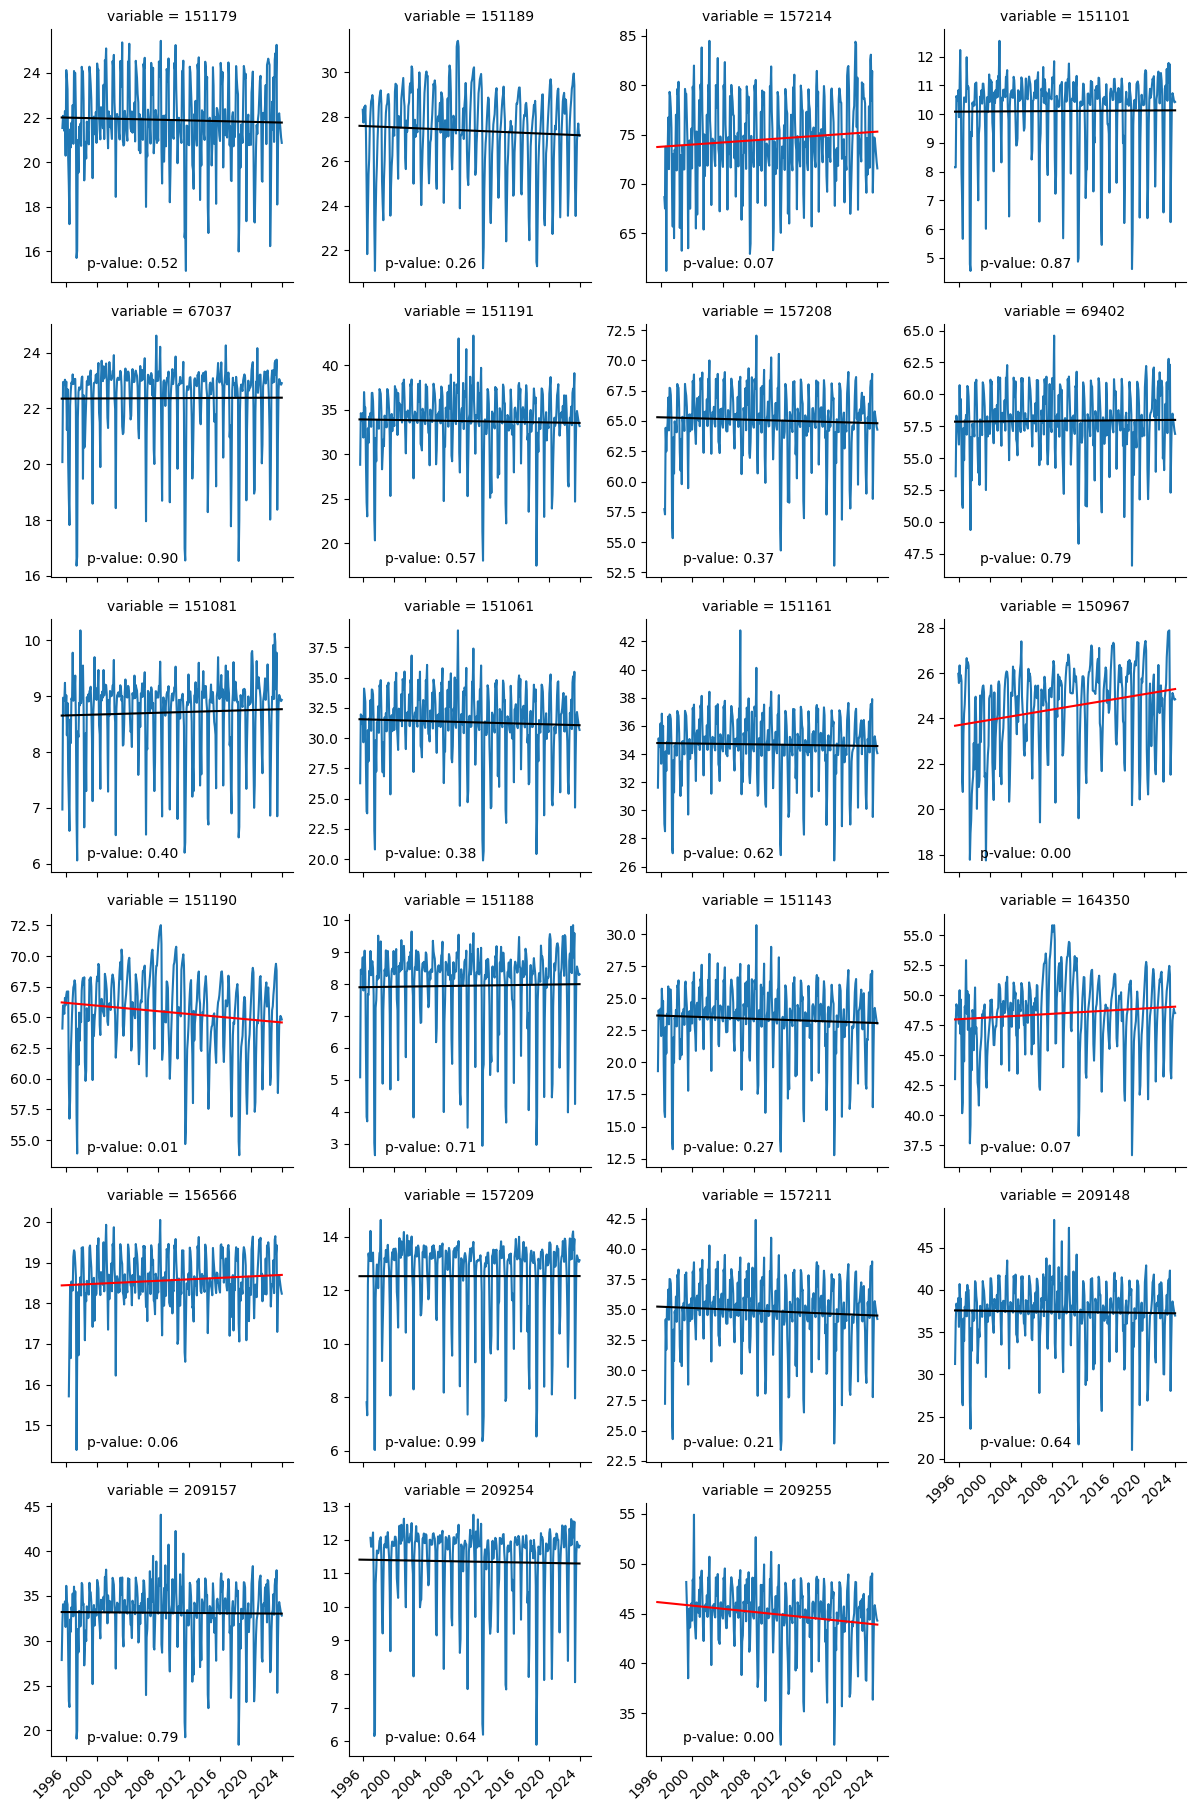

In [30]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(plot_data_and_trendline)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()